In [152]:

from FNFTpy import nsev
import numpy as np
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
import timeit
import pickle
import sys
from tqdm import tqdm
from signal_generation import get_energy
import matplotlib.pyplot as plt
import matplotlib

import signal_generation as sg
import nft_analyse as nft
from importlib import reload
reload(sg)
reload(nft)


<module 'nft_analyse' from '/home/esf0/PycharmProjects/nn_training/nft_analyse.py'>

In [ ]:
def get_metric_old(init_real, init_imag, predict_real, predict_imag):
    # mean = np.mean(np.power(np.absolute((init_real - predict_real) + 1.0j * (init_imag - predict_imag)), 2))
    # mean = np.mean(np.absolute((init_real - predict_real) / init_real + 1.0j * (init_imag - predict_imag) / init_imag)) # this is very big for small values
    mean = np.max(np.absolute((init_real - predict_real) + 1.0j * (init_imag - predict_imag)))

    return mean


def get_metric(init_real, init_imag, predict_real, predict_imag):
    mean = np.mean(np.absolute((init_real - predict_real) + 1.0j * (init_imag - predict_imag))) / np.mean(
        np.absolute(init_real + 1.0j * init_imag))
    # mean = np.mean(np.absolute((init_real - predict_real) / init_real + 1.0j * (init_imag - predict_imag) / init_imag)) # this is very big for small values

    return mean


# def get_metric_normalized(init_real, init_imag, predict_real, predict_imag):
#     mean_real, mean_imag = get_metric(init_real, init_imag, predict_real, predict_imag)
#
#     return mean_real / np.mean(init_real), mean_imag / np.mean(init_imag)


t_span = 1.
n_span = 1024
dt = t_span / n_span
t = np.linspace(-t_span / 2., t_span / 2. - dt, n_span)

# xi_span = np.pi / (2. * dt)
# dxi = xi_span / n_span
# xi = np.linspace(-xi_span / 2., xi_span / 2. - dxi, n_span)


n_xi = 2**10
xi_span = 4. / (2. * dt)
d_xi = xi_span / n_xi
xi = np.zeros(n_xi)

for k in range(n_xi):
    xi[k] = (k - 511) * np.pi


noise_level_range = [9999]
metric_values = []
metric_values_old = []

init_spec = []
init_spec_b = []

noise_level = 9999
test_data = np.load("/home/esf0/PycharmProjects/nn_training/data/test_data_cont_spec_wdm_wo_sol_nl_"
                    + str(noise_level) + ".npy", allow_pickle=True)
print("Training data loaded: SNR =", noise_level, "; size =", len(test_data))

test_signal = test_data[0] + 1.0j * test_data[1]
test_spec = test_data[2] + 1.0j * test_data[3]
# N_VAL = len(test_signal)
N_VAL = 100

tic = timeit.default_timer()
energy_level_range = [0.01, 0.1, 1, 10] + [11 + i for i in range(90)] + [100, 1000, 10000]
# energy_level_range = [0.01, 0.1, 1, 10, 39, 100, 1000, 10000]
# energy_level_range = [39]

for energy_level in energy_level_range:


    metric_total_sum = 0
    metric_old_total_sum = 0

    for ind in tqdm(range(N_VAL)):
        q = test_signal[ind] * np.sqrt(energy_level / 39.)
        # print("Energy:", get_energy(q, dt))

        # Here we calculate NFT spec
        res = nsev(q, t, M=n_span, Xi1=xi[0], Xi2=xi[-1], kappa=1)
        cont_spec = res['cont_ref']

        # Here we calculate FT spec
        ft_spec = fftshift(fft(q))[::-1] / len(q)

        metric_total_sum += get_metric(np.real(ft_spec), np.imag(ft_spec), np.real(cont_spec),
                                       np.imag(cont_spec))
        metric_old_total_sum += get_metric_old(np.real(ft_spec), np.imag(ft_spec), np.real(cont_spec),
                                               np.imag(cont_spec))

        # print("Metric old value:", ind, get_metric_old(np.real(ft_spec), np.imag(ft_spec), np.real(cont_spec),
        #                                        np.imag(cont_spec)))


    metric_values.append(metric_total_sum / N_VAL)
    metric_values_old.append(metric_old_total_sum / N_VAL)
    print("Metric value:", metric_values[-1])
    print("Metric old value:", metric_values_old[-1])

    toc = timeit.default_timer()
    print("SNR =", noise_level, ":", toc - tic, "s")  # elapsed time in seconds

print("Metric:", metric_values)
print("Metric old:", metric_values_old)

plot_f = fftshift(fftfreq(n_span, d=dt))
plot_ft_spec = ft_spec
# print(plot_ft_spec)



fig, axs = plt.subplots(3, 1)
axs[0].plot(t, np.absolute(q))
axs[0].set_xlim(-t_span / 2, t_span / 2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Power')
axs[0].grid(True)

axs[1].plot(abs(cont_spec - plot_ft_spec))
# axs[1].set_xlim(-np.pi / t_span * nt / (2 * np.pi), np.pi / t_span * nt / (2 * np.pi))
# axs[1].set_xlim(-xi_span / 2, xi_span / 2)
# axs[1].set_xlabel('Xi')
axs[1].set_ylabel('Spectral Power')
axs[1].set_yscale('log')
axs[1].grid(True)

axs[2].plot(np.absolute(cont_spec), 'red')
axs[2].plot(np.absolute(plot_ft_spec), 'blue')
axs[2].set_xlim(480, 540)
axs[2].set_xlabel('Freq')
axs[2].set_ylabel('Power')
axs[2].grid(True)


fig.show()

result_all = {'metric_old': metric_values_old, 'energy': energy_level_range}
with open('../results/nft_vs_ft/result_metric.pkl', 'wb') as output:
    pickle.dump(result_all, output, pickle.HIGHEST_PROTOCOL)

# result_all = {'signal': q, 'cont_spec': cont_spec, 'ft_spec': plot_ft_spec}
# with open('../results/nft_vs_ft/result_' + str(39) + '.pkl', 'wb') as output:
#     pickle.dump(result_all, output, pickle.HIGHEST_PROTOCOL)

Check for WDM

In [116]:
import numpy as np
import random
import signal_generation as sg
from importlib import reload
reload(sg)

<module 'signal_generation' from '/home/esf0/PycharmProjects/nn_training/signal_generation.py'>

2.59854704784869
40 [ 1.48746355+0.00594286j  1.48029872+0.01540434j  1.42270321+0.00343246j
  1.32748531+0.02018649j  1.19399294+0.01019288j  1.13596696+0.0015985j
  1.01088267+0.01169529j  0.98345264+0.00371142j  0.95400227+0.00399564j
  0.85215047+0.01523204j  0.77873122+0.00925799j  0.74428249+0.0020675j
  0.6587026 +0.01058648j  0.57021647+0.01119614j  0.53227288+0.00324511j
  0.45731654+0.00083381j  0.4278934 +0.00058206j  0.35357762+0.00592314j
  0.32717618+0.02148652j  0.25051387+0.00242082j  0.13245151+0.00271172j
  0.07989019+0.00376322j  0.04775426+0.00322365j  0.00856851+0.00472547j
 -0.11605881+0.00520583j -1.47314531+0.03010464j -1.35542668+0.01284856j
 -1.28028605+0.00274173j -0.30495868+0.00789713j -1.24370761+0.00400101j
 -1.19661744+0.00553161j -0.48200145+0.0395116j  -1.06583111+0.01379386j
 -0.48894872+0.01110368j -0.58650249+0.01436604j -0.9993368 +0.00917656j
 -0.97502935+0.02990261j -0.93110187+0.00688855j -0.87998704+0.00661966j
 -0.78602139+0.01777282j]
8192
(4

<ipython-input-144-7d8f1e70b637>:82: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


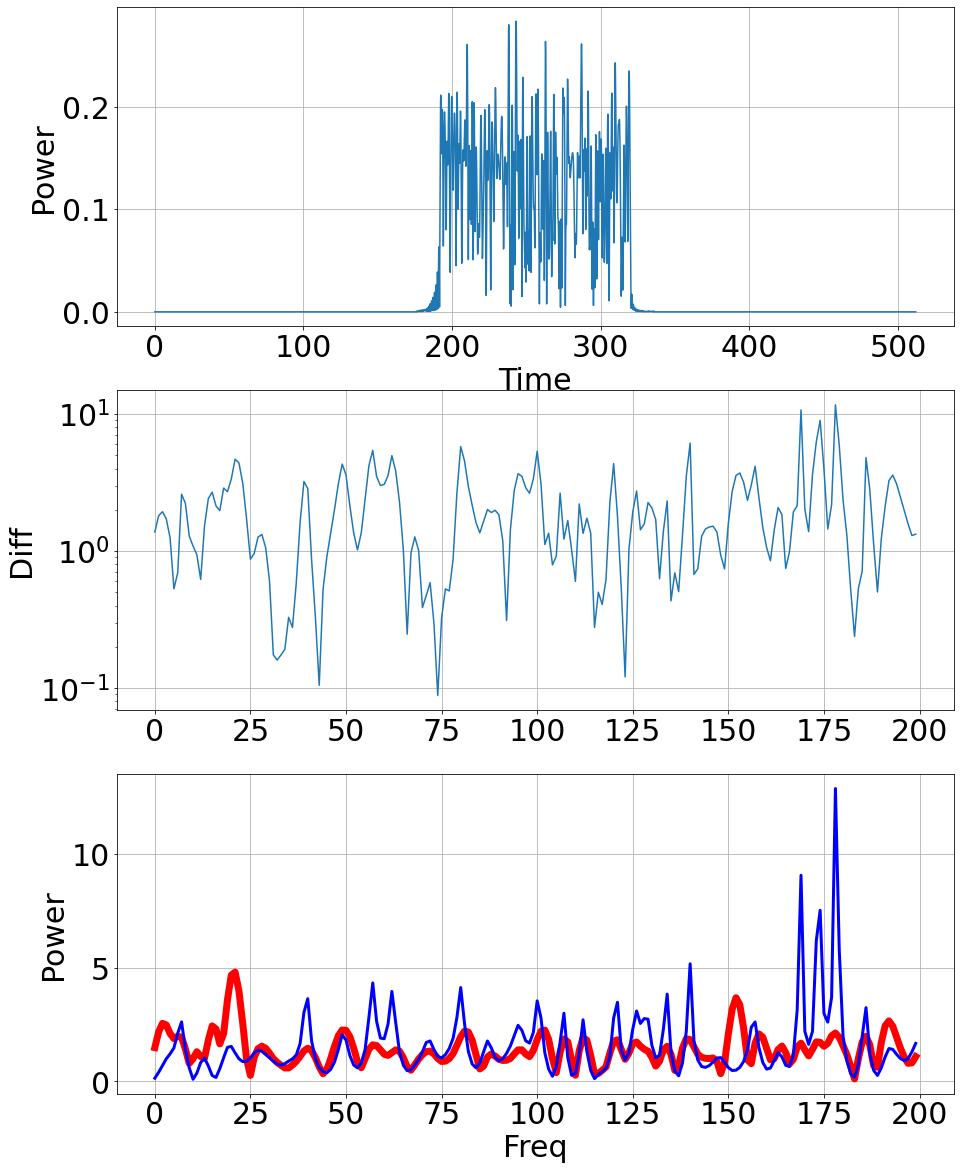

In [144]:
mod_type = "16qam"
n_car = 1
t_symb = 1.
n_symb = 16
num_symbols = 128
n_car = 1
# energy_level_range = [0.01, 0.1, 1, 10] + [11 + i for i in range(90)] + [100, 1000, 10000]
p_ave = 0.02

roll_off = 0.1
n_lateral = 16 * n_symb

dt = t_symb / n_symb

n_bits = n_car * sg.get_n_bits(mod_type) * num_symbols
random.seed(0)
bits = random.getrandbits(n_bits)
data = "{0:b}".format(int(bits))
if len(data) < n_bits:
    data = ''.join('0' for add_bit in range(n_bits - len(data))) + data

signal = sg.get_wdm_signal(data, t_symb, n_symb, sg.srrcos, [t_symb, roll_off],
                           n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral)
signal = sg.set_average_power(signal, dt, p_ave, n_symb * (num_symbols // 2 - 1))
signal = sg.add_lateral(signal, (2**13 - len(signal)) // 2)
t = np.array([i * dt for i in range(len(signal))])
print(get_energy(signal, dt))

n_signal = len(signal)
xi_span = np.pi / (2. * dt) * 2
dxi = xi_span / n_signal
xi = np.linspace(-xi_span / 2. + dxi, xi_span / 2., n_signal)



res_for_ft = nsev(signal, t, M=n_signal, Xi1=xi[0], Xi2=xi[-1], kappa=1, cst=2)
print(res_for_ft['bound_states_num'], res_for_ft['bound_states'])

# ft_xi = np.zeros(n_signal)
# for k in range(n_signal):
#     ft_xi[k] = (k - n_signal // 2 + 1) * np.pi / 20
# # res_for_ft = nsev(signal, t, M=n_signal, Xi1=ft_xi[0], Xi2=ft_xi[-1], kappa=1)
ft_spec = fftshift(fft(signal))[::-1] * dt
ft_f = fftshift(fftfreq(n_signal, d=dt))

nft_spec = res_for_ft['cont_ref']
cont_a = res_for_ft['cont_a']
cont_b = res_for_ft['cont_b']

print(len(signal))
print(max(ft_spec), max(nft_spec))

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(3, 1, figsize=(15, 20))
axs[0].plot(t, np.absolute(signal))
# axs[0].set_xlim(plt_t[0], plt_t[-1])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Power')
axs[0].grid(True)

axs[1].plot(abs(ft_spec[n_signal // 2 - n_lim : n_signal // 2 + n_lim] - nft_spec[n_signal // 2 - n_lim : n_signal // 2 + n_lim]))
# axs[1].set_xlim(-np.pi / t_span * nt / (2 * np.pi), np.pi / t_span * nt / (2 * np.pi))
# axs[1].set_xlim(-xi_span / 2, xi_span / 2)
# axs[1].set_xlabel('Xi')
axs[1].set_ylabel('Diff')
axs[1].set_yscale('log')
axs[1].grid(True)

n_lim = 100
# axs[2].plot(ft_f, np.absolute(ft_spec) * 200, 'red', lw=7)
# axs[2].plot(plt_xi * plt_dt / np.pi / 5.9 - 0.01, np.absolute(plt_nft_spectrum), 'blue', lw=3)
axs[2].plot(np.absolute(ft_spec[n_signal // 2 - n_lim : n_signal // 2 + n_lim]), 'red', lw=7)
axs[2].plot(np.absolute(nft_spec[n_signal // 2 - n_lim : n_signal // 2 + n_lim]), 'blue', lw=3)
# axs[2].set_xlim(-0.6, 0.6)
# axs[2].set_ylim(0, 5)
axs[2].set_xlabel('Freq')
axs[2].set_ylabel('Power')
axs[2].grid(True)


fig.show()

<ipython-input-145-d7cdc32114e4>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


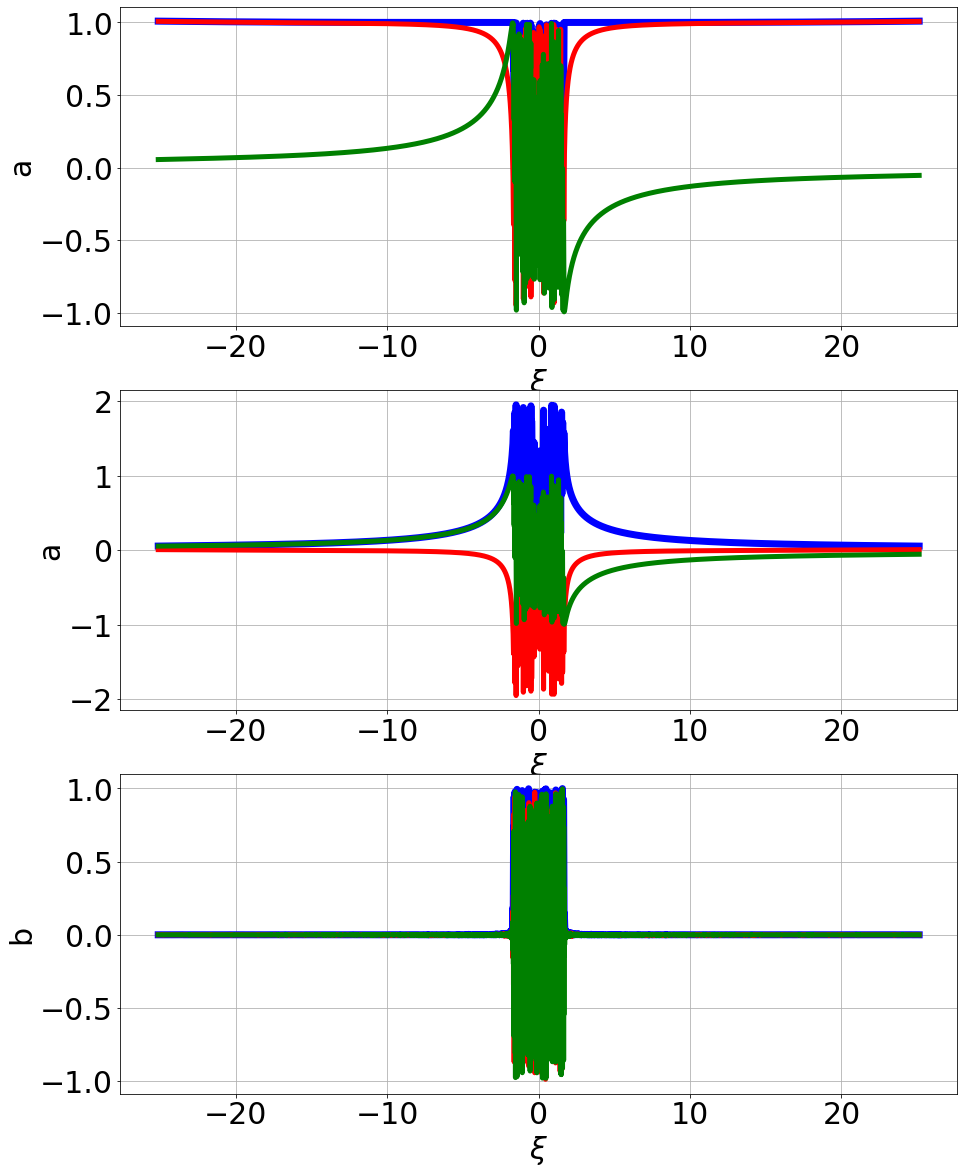

In [145]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(3, 1, figsize=(15, 20))
axs[0].plot(xi, np.absolute(cont_a), 'blue', lw=7)
axs[0].plot(xi, np.real(cont_a), 'red', lw=5)
axs[0].plot(xi, np.imag(cont_a), 'green', lw=5)
# axs[0].set_xlim(plt_t[0], plt_t[-1])
axs[0].set_xlabel(r'$\xi$')
axs[0].set_ylabel(r'a')
axs[0].grid(True)

axs[1].plot(xi, np.absolute(cont_a - 1), 'blue', lw=7)
axs[1].plot(xi, np.real(cont_a - 1), 'red', lw=5)
axs[1].plot(xi, np.imag(cont_a - 1), 'green', lw=5)
# axs[0].set_xlim(plt_t[0], plt_t[-1])
axs[1].set_xlabel(r'$\xi$')
axs[1].set_ylabel(r'a')
axs[1].grid(True)

axs[2].plot(xi, np.absolute(cont_b), 'blue', lw=7)
axs[2].plot(xi, np.real(cont_b), 'red', lw=5)
axs[2].plot(xi, np.imag(cont_b), 'green', lw=5)
# axs[0].set_xlim(plt_t[0], plt_t[-1])
axs[2].set_xlabel(r'$\xi$')
axs[2].set_ylabel(r'b')
axs[2].grid(True)



fig.show()

In [153]:
ph = nft.get_contour_phase_shift_adaptive(q=signal, t=t, xi_cont=xi, a_xi=cont_a)
print(ph)
print(ph[0] / (2. * np.pi))

(276.35186856798236, 0, [{'xi': -1.5769322499464415, 'xi_next': -1.5707963267948983, 'sign': 1}, {'xi': -1.546252634188729, 'xi_next': -1.5401167110371858, 'sign': 1}, {'xi': -1.4910293258248473, 'xi_next': -1.484893402673304, 'sign': 1}, {'xi': -1.3621749396424505, 'xi_next': -1.3560390164909109, 'sign': 1}, {'xi': -1.2885438618239426, 'xi_next': -1.2824079386723994, 'sign': 1}, {'xi': -1.251728322914687, 'xi_next': -1.2455923997631437, 'sign': 1}, {'xi': -1.2026409377023448, 'xi_next': -1.1965050145508016, 'sign': 1}, {'xi': -1.0737865515199516, 'xi_next': -1.0676506283684084, 'sign': 1}, {'xi': -1.0124273200045266, 'xi_next': -1.0062913968529834, 'sign': 1}, {'xi': -0.9756117810952709, 'xi_next': -0.9694758579437277, 'sign': 1}, {'xi': -0.932660319034472, 'xi_next': -0.9265243958829288, 'sign': 1}, {'xi': -0.8835729338221334, 'xi_next': -0.8774370106705902, 'sign': 1}, {'xi': -0.7915340865489924, 'xi_next': -0.7853981633974527, 'sign': 1}, {'xi': -0.6657476619423708, 'xi_next': -0.6